This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Zonal Statistics - Cartesian Grid


In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np
import xarray as xr

## Setup Examples

In [2]:
def testplot(
    ds,
    obj,
    col="mean",
    levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    title="",
):
    """Quick test plot layout for this example file"""
    colors = plt.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100]
    radocolors = plt.cm.viridis(np.linspace(0, 1, len(radolevels)))
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors, extend="max")

    fig = plt.figure(figsize=(10, 16))

    # Average rainfall sum
    ax = fig.add_subplot(211, aspect="equal")
    obj.zdata.trg.geo.plot(
        column=col,
        ax=ax,
        cmap=mycmap,
        norm=mynorm,
        edgecolor="white",
        lw=0.5,
        legend=True,
        legend_kwds=dict(shrink=0.5),
    )
    ax.autoscale()
    plt.xlabel("UTM Zone 32 Easting")
    plt.ylabel("UTM Zone 32 Northing")
    plt.title(title)
    plt.draw()

    # Original radar data
    ax1 = fig.add_subplot(212, aspect="equal")
    pm = ds.plot(
        x="xc",
        y="yc",
        cmap=radocmap,
        norm=radonorm,
        ax=ax1,
        cbar_kwargs=dict(shrink=0.5),
    )
    obj.zdata.trg.geo.plot(ax=ax1, facecolor="None", edgecolor="white")
    plt.xlabel("UTM Zone 32 Easting")
    plt.ylabel("UTM Zone 32 Northing")
    plt.title("Original radar rain sums")
    plt.draw()
    plt.tight_layout()

In [3]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches
import datetime as dt
from osgeo import osr

In [4]:
# check for GEOS enabled GDAL
if not wrl.util.has_geos():
    print("NO GEOS support within GDAL, aborting...")
    exit(0)

In [5]:
# Read and prepare the actual data (RADOLAN)
f = wrl.util.get_wradlib_data_file(
    "radolan/misc/raa01-sf_10000-1406100050-dwd---bin.gz"
)
ds = wrl.io.open_radolan_dataset(f)
display(ds)

<xarray.Dataset>
Dimensions:  (y: 900, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2014-06-10T00:50:00
  * y        (y) float64 -4.658e+06 -4.657e+06 ... -3.76e+06 -3.759e+06
  * x        (x) float64 -5.23e+05 -5.22e+05 -5.21e+05 ... 3.75e+05 3.76e+05
Data variables:
    SF       (y, x) float32 ...
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.13.1
    radarlocations:  ['asw', 'boo', 'emd', 'han', 'umd', 'pro', 'ess', 'drs',...
    radardays:       ['asw 10', 'boo 24', 'drs 24', 'emd 24', 'ess 24', 'fbg ...

In [6]:
# create radolan projection osr object
if ds.attrs["formatversion"] >= 5:
    proj_stereo = wrl.georef.create_osr("dwd-radolan-wgs84")
else:
    proj_stereo = wrl.georef.create_osr("dwd-radolan-sphere")

# create UTM Zone 32 projection osr object
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)

# Source projection of the shape data (in GK2)
proj_gk2 = osr.SpatialReference()
proj_gk2.ImportFromEPSG(31466)

0

In [7]:
def write_prj(filename, proj):
    with open(filename, "w") as f:
        f.write(proj.ExportToWkt())

In [8]:
print(proj_stereo)

PROJCS["Radolan Projection",
    GEOGCS["Radolan Coordinate System",
        DATUM["Radolan_Kugel",
            SPHEROID["Erdkugel",6370040,0]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",60],
    PARAMETER["central_meridian",10],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",SOUTH],
    AXIS["Northing",SOUTH]]


In [9]:
flist = ["shapefiles/agger/agger_merge.shx", "shapefiles/agger/agger_merge.dbf"]
[wrl.util.get_wradlib_data_file(f) for f in flist]

shpfile = wrl.util.get_wradlib_data_file("shapefiles/agger/agger_merge.shp")
write_prj(shpfile[:-3] + "prj", proj_gk2)
trg = wrl.io.VectorSource(shpfile, trg_crs=proj_utm, name="trg")
print(f"Found {len(trg)} sub-catchments in shapefile.")

Found 13 sub-catchments in shapefile.


In [10]:
print(trg.crs)

PROJCS["WGS 84 / UTM zone 32N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32632"]]


In [11]:
bbox = trg.extent
buffer = 5000.0
bbox = dict(
    left=bbox[0] - buffer,
    right=bbox[1] + buffer,
    bottom=bbox[2] - buffer,
    top=bbox[3] + buffer,
)
print(bbox)

{'left': 365059.5928799211, 'right': 419830.11388741195, 'bottom': 5624046.706676126, 'top': 5668055.540990271}


In [12]:
# Get RADOLAN grid coordinates
x_rad, y_rad = np.meshgrid(ds.x, ds.y)
grid_xy_radolan = np.stack([x_rad, y_rad], axis=-1)

# Reproject the RADOLAN coordinates
xy = wrl.georef.reproject(grid_xy_radolan, src_crs=proj_stereo, trg_crs=proj_utm)

# assign as coordinates
ds = ds.assign_coords(
    {
        "xc": (
            ["y", "x"],
            xy[..., 0],
            dict(long_name="UTM Zone 32 Easting", units="m"),
        ),
        "yc": (
            ["y", "x"],
            xy[..., 1],
            dict(long_name="UTM Zone 32 Northing", units="m"),
        ),
    }
)
ds_clip = ds.where(
    (
        ((ds.yc > bbox["bottom"]) & (ds.yc < bbox["top"]))
        & ((ds.xc > bbox["left"]) & (ds.xc < bbox["right"]))
    ),
    drop=True,
)
display(ds_clip)

<xarray.Dataset>
Dimensions:  (y: 47, x: 58, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2014-06-10T00:50:00
  * y        (y) float64 -4.233e+06 -4.232e+06 ... -4.188e+06 -4.187e+06
  * x        (x) float64 -2.15e+05 -2.14e+05 -2.13e+05 ... -1.59e+05 -1.58e+05
    xc       (y, x) float64 3.655e+05 3.664e+05 ... 4.179e+05 4.189e+05
    yc       (y, x) float64 5.624e+06 5.624e+06 ... 5.669e+06 5.669e+06
Data variables:
    SF       (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.13.1
    radarlocations:  ['asw', 'boo', 'emd', 'han', 'umd', 'pro', 'ess', 'drs',...
    radardays:       ['asw 10', 'boo 24', 'drs 24', 'emd 24', 'ess 24', 'fbg ...

## Zonal Stats - Rectangular Grid - Points

In [13]:
###########################################################################
# Approach #1: Assign grid points to each polygon and compute the average.
#
# - Uses matplotlib.path.Path
# - Each point is weighted equally (assumption: polygon >> grid cell)
# - this is quick, but theoretically dirty
###########################################################################

t1 = dt.datetime.now()

# Get RADOLAN center grid points for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grid_x, grid_y = np.meshgrid(ds_clip.x, ds_clip.y)
grdpoints = np.dstack([grid_x, grid_y]).reshape(-1, 2)

src = wrl.io.VectorSource(grdpoints, trg_crs=proj_utm, name="src", src_crs=proj_stereo)
trg = wrl.io.VectorSource(shpfile, trg_crs=proj_utm, name="trg", src_crs=proj_gk2)

# Create instance of type ZonalDataPoint from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoint(src, trg=trg, crs=proj_utm, buf=500.0)
# dump to file (for later use - see below)
zd.dump_vector("test_zonal_points_cart")
# Create instance of type ZonalStatsPoint from zonal data object
obj1 = wrl.zonalstats.ZonalStatsPoint(zd)

isecs1 = obj1.zdata.isecs  # for plotting (see below)

t2 = dt.datetime.now()

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoint from zonal data file
# (much faster)
obj1 = wrl.zonalstats.ZonalStatsPoint("test_zonal_points_cart")

# Compute stats for target polygons
avg1 = obj1.mean(ds_clip.SF.values.ravel())
var1 = obj1.var(ds_clip.SF.values.ravel())

zd.dump_vector("test_zonal_points_cart")


t4 = dt.datetime.now()

print("Approach #1 computation time:")
print("\tCreate object from scratch: %f " "seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f " "seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f " "seconds" % (t3 - t2).total_seconds())

# PLOTTING Approach #1

src = wrl.io.VectorSource(grdpoints, trg_crs=proj_utm, name="src", src_crs=proj_stereo)
trg = wrl.io.VectorSource(shpfile, trg_crs=proj_utm, name="trg", src_crs=proj_gk2)
# Just a test for plotting results with zero buffer
zd2 = wrl.zonalstats.ZonalDataPoint(src, trg=trg, buf=0)
# Create instance of type ZonalStatsPoint from zonal data object
obj2 = wrl.zonalstats.ZonalStatsPoint(zd2)
# copy attributes to target layer
obj2.zdata.trg.set_attribute("mean", avg1)
obj2.zdata.trg.set_attribute("var", var1)
isecs2 = obj2.zdata.isecs

Approach #1 computation time:
	Create object from scratch: 2.743697 seconds
	Create object from dumped file: 0.166231 seconds
	Compute stats using object: 0.000049 seconds


Text(0.5, 1.0, 'Catchment #6: Points considered for stats')

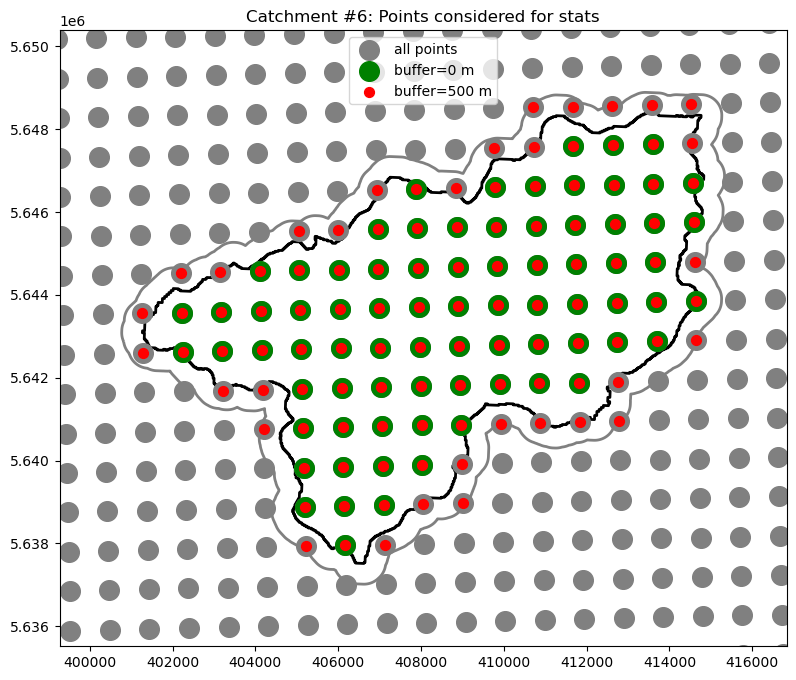

In [14]:
# Illustrate results for an example catchment i
i = 6  # try e.g. 5, 2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")

# Target polygon patches
trg_patch = obj2.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=2)
trg_patch = obj1.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="grey", linewidth=2)

# pips
sources = obj1.zdata.src.geo
sources.plot(ax=ax, label="all points", c="grey", markersize=200)
isecs1 = obj2.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(ax=ax, label="buffer=0 m", c="green", markersize=200)
isecs2 = obj1.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs2.plot(ax=ax, label="buffer=500 m", c="red", markersize=50)

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
plt.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
plt.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
plt.legend()
plt.title("Catchment #%d: Points considered for stats" % i)

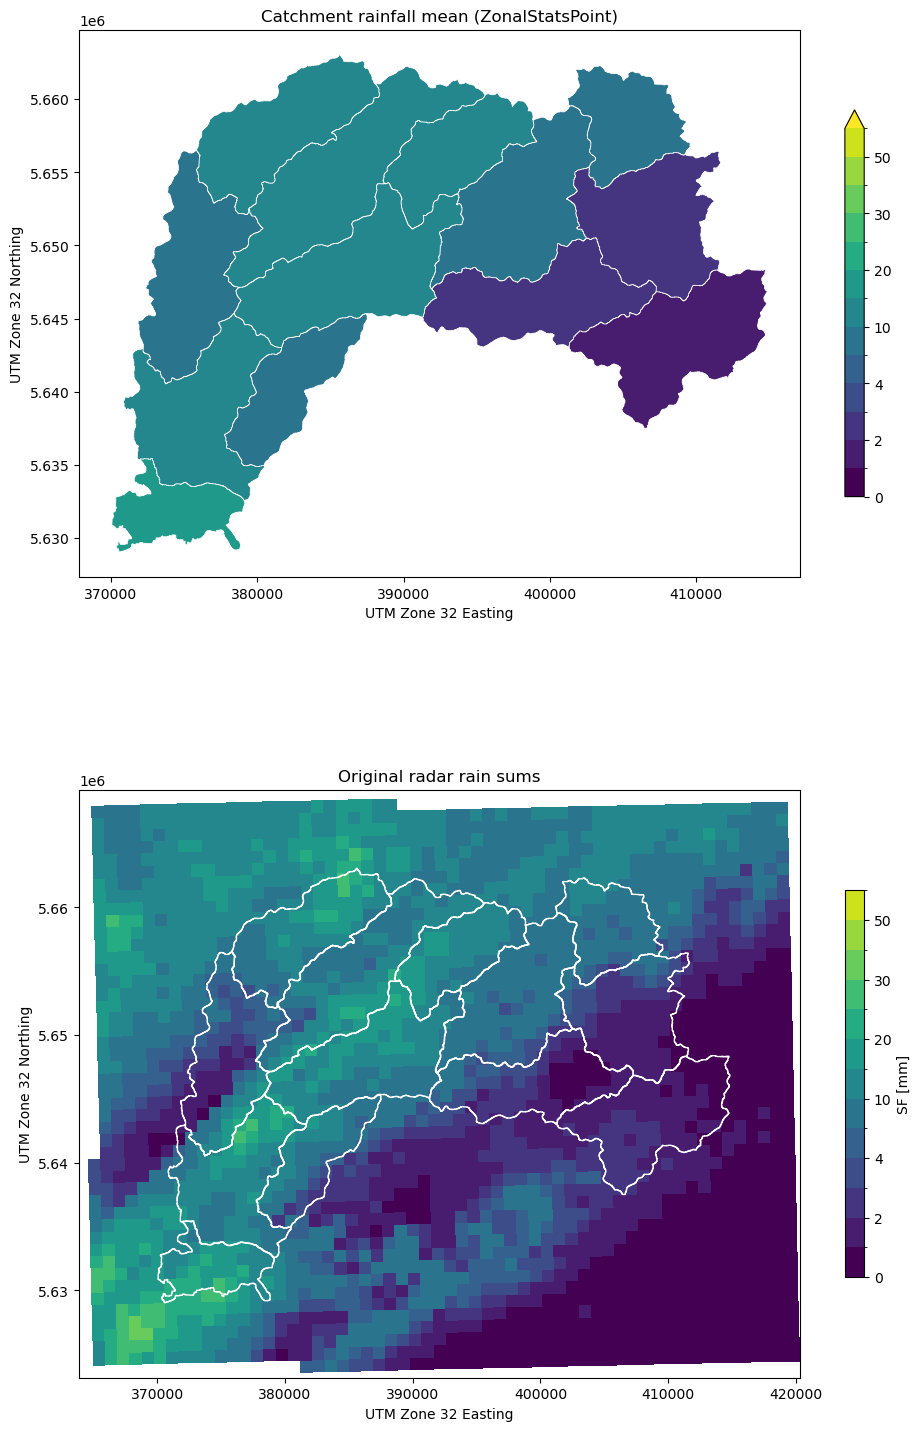

In [15]:
# Plot average rainfall and original data
testplot(
    ds_clip.SF, obj2, col="mean", title="Catchment rainfall mean (ZonalStatsPoint)"
)

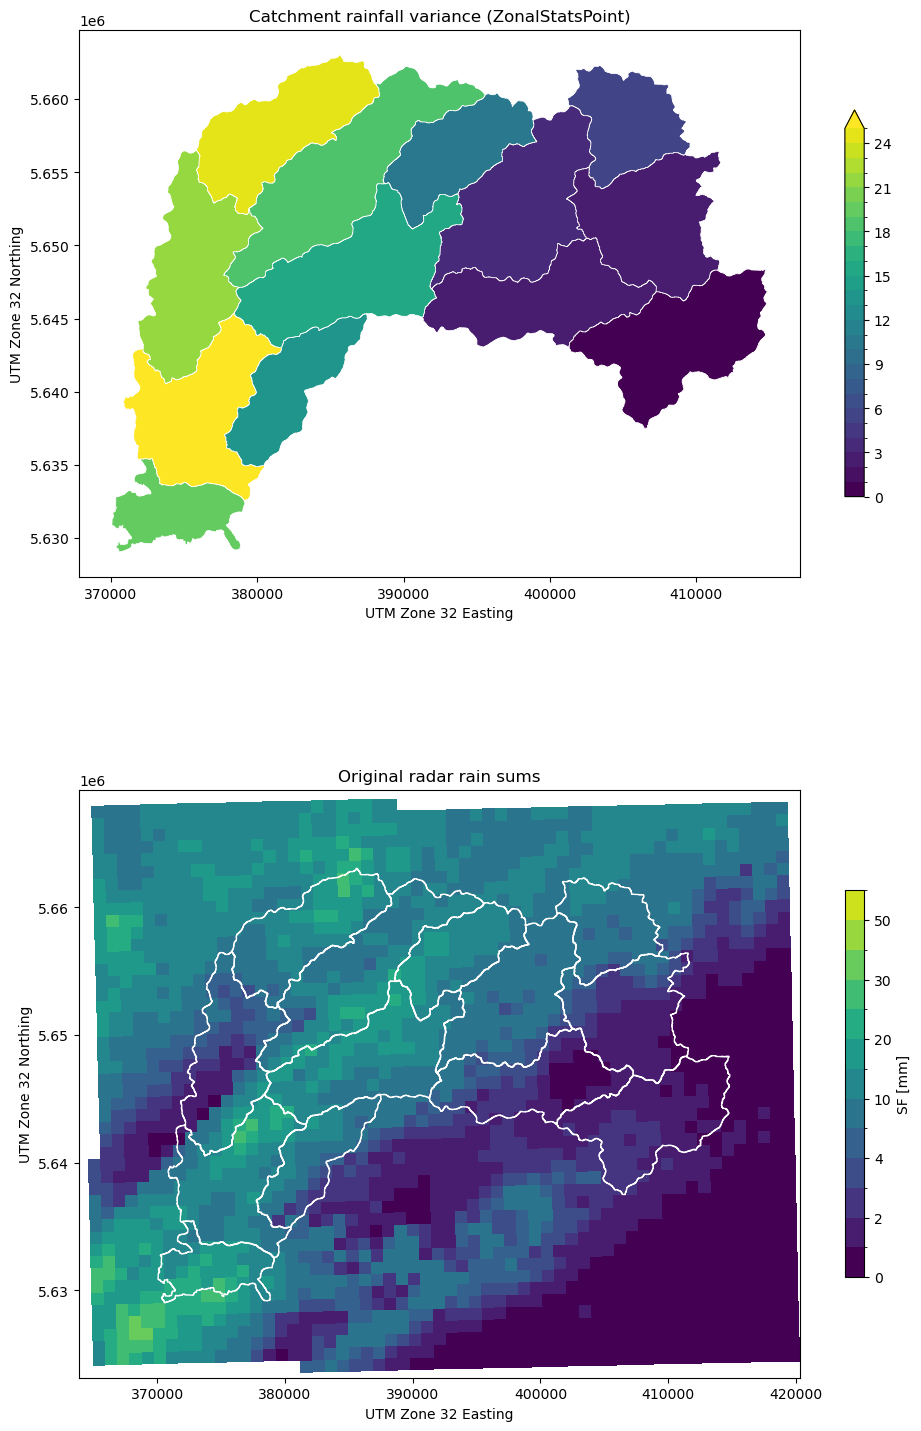

In [16]:
testplot(
    ds_clip.SF,
    obj2,
    col="var",
    levels=np.arange(0, np.max(var1), 1.0),
    title="Catchment rainfall variance (ZonalStatsPoint)",
)

## Zonal Stats - Rectangular Grid - Polygons¶

In [17]:
###########################################################################
# Approach #2: Compute weighted mean based on fraction of source polygons
# in target polygons
#
# - This is more accurate (no assumptions), but probably slower...
###########################################################################

# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grid_x, grid_y = np.meshgrid(ds_clip.x, ds_clip.y)
gridres = ds.x.diff("x")[0].values
grdverts = wrl.zonalstats.grid_centers_to_vertices(grid_x, grid_y, gridres, gridres)
# And reproject to Cartesian reference system (here: UTM Zone 32)
src = wrl.io.VectorSource(grdverts, trg_crs=proj_utm, name="src", src_crs=proj_stereo)
trg = wrl.io.VectorSource(shpfile, trg_crs=proj_utm, name="trg", src_crs=proj_gk2)

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(src, trg=trg, crs=proj_utm)
# dump to file
zd.dump_vector("test_zonal_poly_cart")
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

t2 = dt.datetime.now()

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from zonal data file
obj3 = wrl.zonalstats.ZonalStatsPoly("test_zonal_poly_cart")
# Compute stats for target polygons
avg3 = obj3.mean(ds_clip.SF.values.ravel())
var3 = obj3.var(ds_clip.SF.values.ravel())

t4 = dt.datetime.now()

print("Approach #2 computation time:")
print("\tCreate object from scratch: %f " "seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f " "seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f " "seconds" % (t3 - t2).total_seconds())

Approach #2 computation time:
	Create object from scratch: 0.293567 seconds
	Create object from dumped file: 0.120747 seconds
	Compute stats using object: 0.000052 seconds


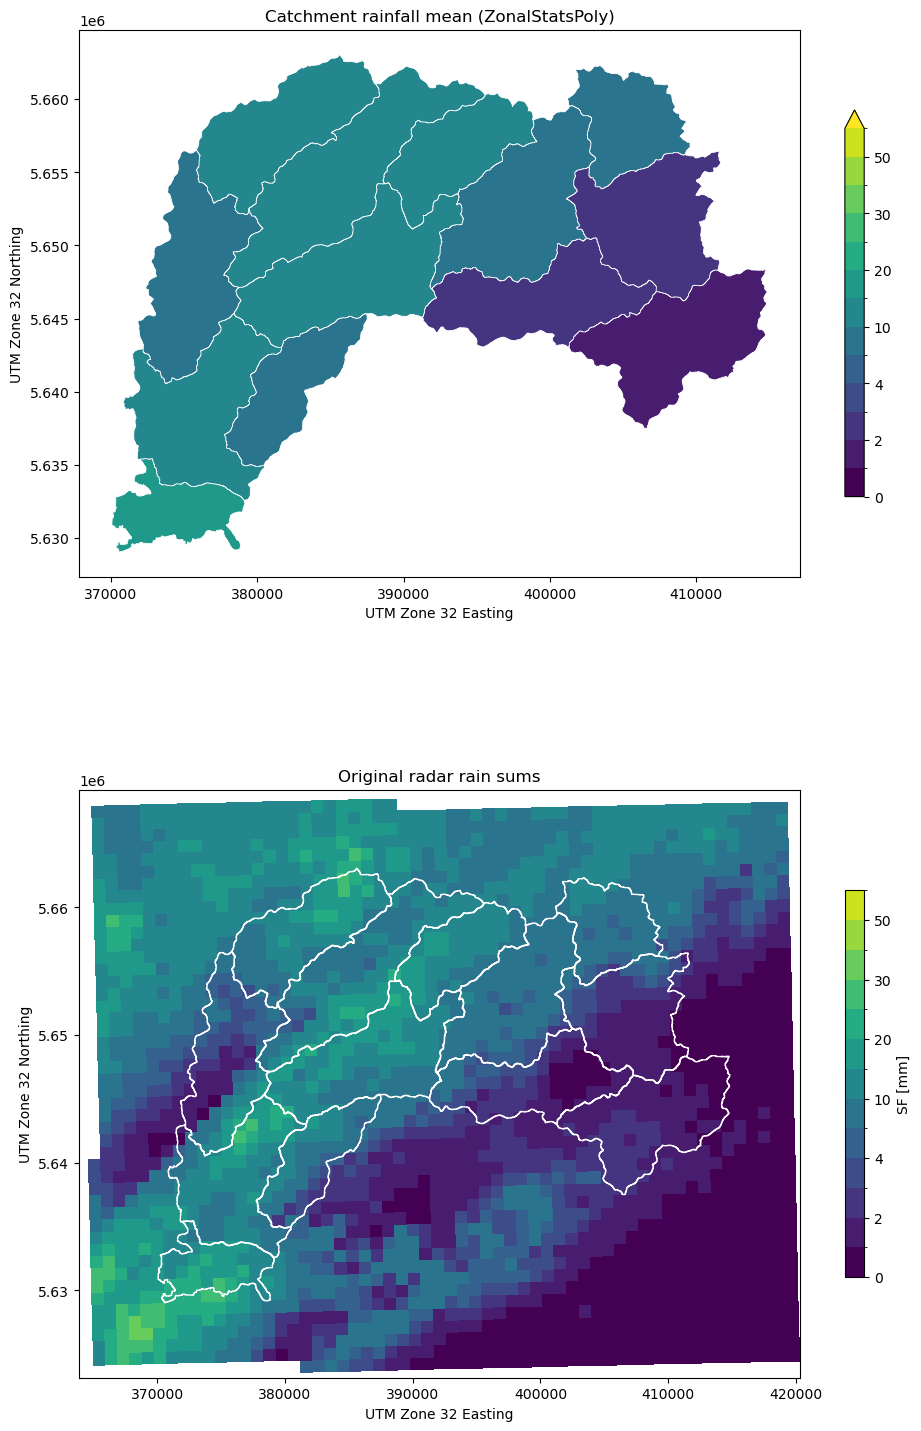

In [18]:
# Plot average rainfall and original data
testplot(ds_clip.SF, obj3, col="mean", title="Catchment rainfall mean (ZonalStatsPoly)")

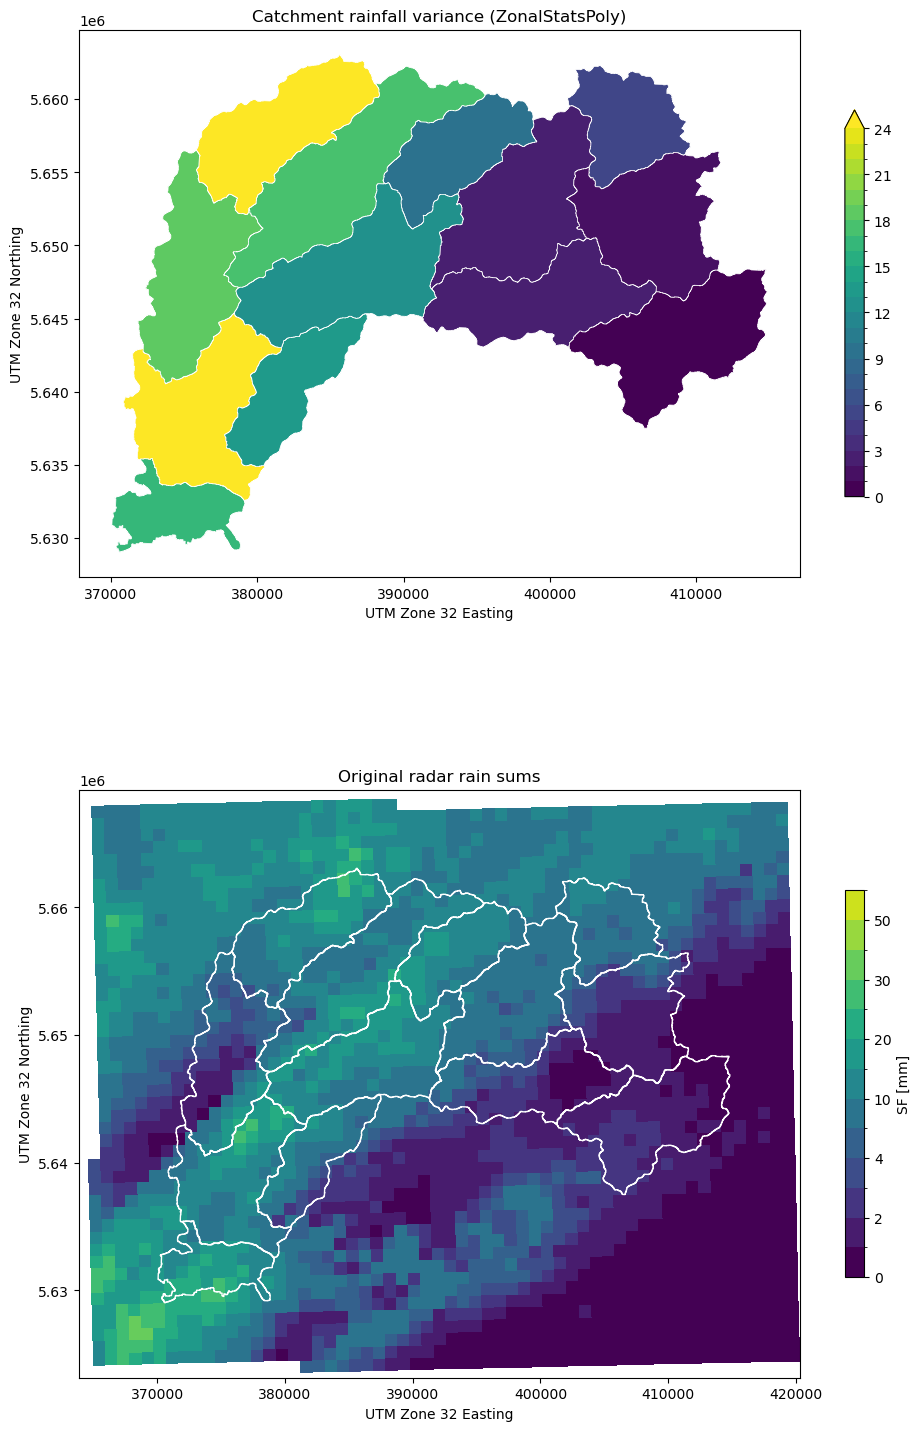

In [19]:
testplot(
    ds_clip.SF,
    obj3,
    col="var",
    levels=np.arange(0, np.max(var3), 1.0),
    title="Catchment rainfall variance (ZonalStatsPoly)",
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Catchment #6: Polygons considered for stats')

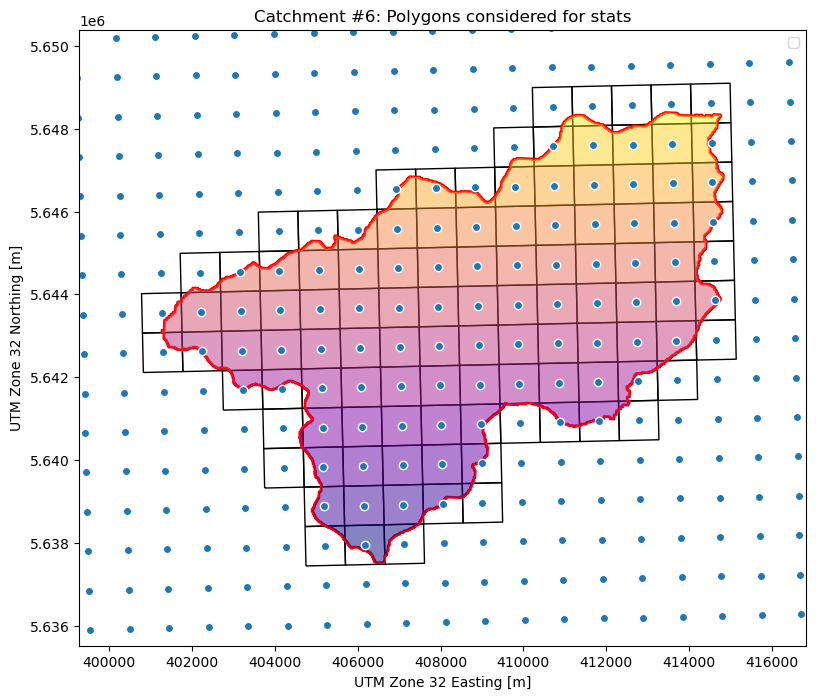

In [20]:
# Illustrate results for an example catchment i
i = 6  # try e.g. 5, 2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")

# Grid cell patches
src_index = obj3.zdata.get_source_index(i)
trg_patch = obj3.zdata.src.get_data_by_idx(src_index, mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black")

# Target polygon patches
trg_patch = obj3.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="red", linewidth=2)

# intersections
isecs1 = obj3.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(column="src_index", ax=ax, cmap=plt.cm.plasma, alpha=0.5)

# scatter center points
ds_clip.plot.scatter(x="xc", y="yc")

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
plt.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
plt.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
plt.legend()
plt.title("Catchment #%d: Polygons considered for stats" % i)

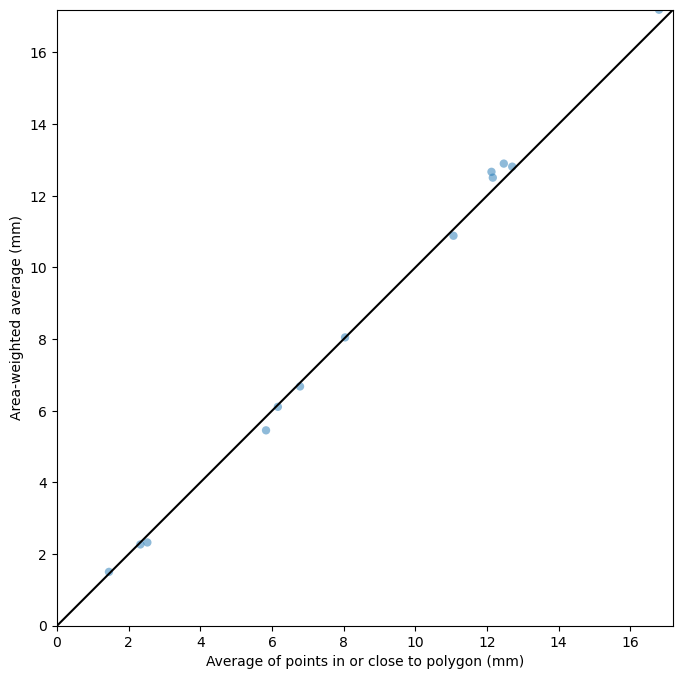

In [21]:
# Compare estimates
maxlim = np.max(np.concatenate((avg1, avg3)))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")
plt.scatter(avg1, avg3, edgecolor="None", alpha=0.5)
plt.xlabel("Average of points in or close to polygon (mm)")
plt.ylabel("Area-weighted average (mm)")
plt.xlim(0, maxlim)
plt.ylim(0, maxlim)
plt.plot([-1, maxlim + 1], [-1, maxlim + 1], color="black")
plt.show()